In [1]:
# Выполнение одного набора xgbooster (JPG, дибо TIF) (2017-07-03)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trWork, teWork = '../Work/Train', '../Work/Test'
print (trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [14]:
# Данные для обработки
binsData = 256
jpgtif   = '.jpg'
trX      = np.load('../Work/t-'+str(10000+binsData)+jpgtif+'-XX-train.npy')
trY      = np.load('../Work/t-'+str(10000+binsData)+jpgtif+'-YY-train.npy')

In [22]:
print (trX.shape,trY.shape,((768/3)*3))

(40479, 768) (40479, 17) 768


In [23]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,0])

In [24]:
# Построение списка bst - моделей
def getListBST (param, trX, trY, nfold=3, early_stop=20) :
    dtrain = xgb.DMatrix(trX,label=trY[:,0])
    results, bstList = [], []
    for i in range(trY.shape[1]) :
        print ('Working: {}'.format(i))
        dtrain.set_label(trY[:,i])
        history = xgb.cv(param, dtrain, metrics=['auc'], 
                         verbose_eval=30, num_boost_round=5000, nfold=nfold, 
                         early_stopping_rounds=early_stop)
        results.append(history)
        rvalidCV, watchlistCV = {}, [(dtrain,'train')]
        bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
        bstList.append(bst)
    return(bstList)

# Построение решения по dmatrix и bst списку
def buildPredict (dData, bstList) :
    trYP = []
    for bstI in bstList :
        trYP1 = bstI.predict(dData); trYP.append(trYP1)
    trYP = np.array(trYP).T
    #type(trYP),trYP.shape
    return(trYP)

# Построение решения по np.array (DataFrame?) и bst списку
def buildPredictX (Data, bstList) :
    dData = xgb.DMatrix(Data);
    return (buildPredict(dData,bstList))

In [25]:
# Процедуры для оценки результативности

def getConfusion (tGroundTrue, tPredict) :
    cList = []
    for i in range(tPredict.shape[1]) :
        cList.append(skm.confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(cList))

def getRocAUC (tGroundTrue, tPredict) :
    rList = []
    for i in range(tPredict.shape[1]) :
        rList.append(skm.roc_auc_score(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(rList))

In [26]:
# Построение пределов прохождения для предсказанного
def getTh (tGround,tPredict, prec=100 ) :
    ixx,iacc = [], []
    for i in range(tGround.shape[1]) :
        max, maxxx = 0.0, 0.0
        for xx in range(0,prec+1) :
            tempYP = getProb01(tPredict[:,i],th=(float(xx)/prec)); #print(tPredict[:,1],tempYP[0])
            temp = skm.accuracy_score(tGround[:,i],tempYP)
            #print(float(xx/10.0),temp)
            if (temp>max) : 
                max = temp; maxxx = float(xx)
                temp = skm.confusion_matrix(tGround[:,i],tempYP);
                minloss = temp[0][1]+temp[1][0]
        ixx.append(maxxx)
        tempYP = getProb01 (tPredict[:,i])
        temp = skm.accuracy_score(tGround[:,i],tempYP)
        minloss05 = skm.confusion_matrix(tGround[:,i],tempYP);
        minloss05 = minloss05[0][1]+minloss05[1][0]
        iacc.append((maxxx,max,temp,minloss,minloss05))
    ixx = [float(xx/prec) for xx in ixx]
    return (ixx,iacc)

In [27]:
# Оценка нескольких наборов
def getProb01 (trYP, th=0.5) :
    trYY = trYP.copy()
    trYY[trYY<th] = 0
    trYY[trYY>0]  = 1
    return (trYY)

def estimateTrain (estimateList, param) :
    res = []
    for jpgtif, bins in estimateList :
        trX     = np.load('../Work/train-data-XX'+str(bins)+jpgtif+'.npy')
        trY     = np.load('../Work/train-data-YY'+str(bins)+jpgtif+'.npy')
        listBST = getListBST(param, trX, trY)
        trYP    = buildPredictX(trX,listBST)
        trYY    = getProb01(trYP)
        res.append(np.array(getConfusion(trY,trYY)))
    return(res)      

In [28]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

In [29]:
# Считаем около 40 минут
print(datetime.datetime.now(),'Begin')
bstList = getListBST(param,trX,trY)
print(datetime.datetime.now(),'End')

2017-07-04 01:05:30.422187 Begin
Working: 0
[0]	train-auc:0.943547+0.00524291	test-auc:0.929328+0.00505594
[30]	train-auc:0.988459+0.000516729	test-auc:0.958506+0.00232698
[60]	train-auc:0.996101+0.000172513	test-auc:0.958487+0.0025079
[0]	train-auc:0.943299	train-rmse:0.377534
[1]	train-auc:0.948933	train-rmse:0.300219
[2]	train-auc:0.958053	train-rmse:0.250566
[3]	train-auc:0.9606	train-rmse:0.220209
[4]	train-auc:0.963582	train-rmse:0.201258
[5]	train-auc:0.966638	train-rmse:0.189529
[6]	train-auc:0.968566	train-rmse:0.182326
[7]	train-auc:0.969726	train-rmse:0.177749
[8]	train-auc:0.970854	train-rmse:0.175135
[9]	train-auc:0.972179	train-rmse:0.172977
[10]	train-auc:0.973048	train-rmse:0.171026
[11]	train-auc:0.974115	train-rmse:0.170041
[12]	train-auc:0.97567	train-rmse:0.168424
[13]	train-auc:0.976395	train-rmse:0.167968
[14]	train-auc:0.977073	train-rmse:0.167384
[15]	train-auc:0.977724	train-rmse:0.16678
[16]	train-auc:0.978741	train-rmse:0.165077
[17]	train-auc:0.979507	train-

In [32]:
# Шаблоны имен файллов для сохранения моделей xgb
fModel1 = '../Work/Models/model-'
fModel2 = str(binsData)+'-'+jpgtif+'.xgb'

In [33]:
# save xgb models into files
for i in range(len(bstList)) :
    ##bstList[i].save_model(fModel1+str(100+i)+'-JPG2'+fModel2)
    bstList[i].save_model(fModel1+str(100+i)+fModel2)

In [615]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model(fModel1+str(100+i)+fModel2)
bstList = bstList0
del bstList0
len(bstList)

17

In [34]:
trYP  = buildPredict(dtrain,bstList)
trYPP = trYP.copy() # вероятностный массив
trYP  = getProb01(trYP)
print (trYP.shape, '\n', trYPP[0], '\n', trYP[0])

(40479, 17) 
 [  6.58011138e-01   9.90658760e-01   8.67615826e-03   2.22895697e-01
   1.96270496e-02   2.35312982e-04   7.85448030e-03   8.23995844e-03
   2.78736174e-04   2.39000563e-03   7.48114951e-04   1.23488044e-05
   3.71635030e-03   7.80847586e-06   4.05057974e-04   4.53088083e-04
   4.89163831e-05] 
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [35]:
#accListOld = accList

In [36]:
# Оценка точности предсказания по train массиву по разным методикам
accList = []
for i in range(trYP.shape[1]) :
    print ('#{} accuracy={} precision={} recall={} ros_auc={} fbeta2={} not={}'.format(i, 
                                           skm.accuracy_score(trY[:,i],trYP[:,i]), 
                                           skm.precision_score(trY[:,i],trYP[:,i]), 
                                           skm.recall_score(trY[:,i],trYP[:,i]), 
                                           skm.roc_auc_score(trY[:,i],trYP[:,i]), 
                                           skm.fbeta_score(trY[:,i],trYP[:,i],beta=2),
                                           len(trYP[trYP[:,i]<>trY[:,i],i])))
    accList.append((i, skm.roc_auc_score(trY[:,i],trYP[:,i]), skm.confusion_matrix(trY[:,i],trYP[:,i])))
    #fpr,tpr,thr = skm.roc_curve(trY[:,i],trYP[:,i]); print (len(thr),len(fpr),len(trYP[:,i]))
    #plt.plot(fpr,tpr); plt.show()

#0 accuracy=0.971614911436 precision=0.852459016393 recall=0.694104560623 ros_auc=0.842764524237 fbeta2=0.720887245841 not=1149
#1 accuracy=0.999061241631 precision=0.999360392293 recall=0.999626796044 ros_auc=0.995767545021 fbeta2=0.999573503932 not=38
#2 accuracy=0.93030954322 precision=0.902971137521 recall=0.863743402355 ros_auc=0.911579839226 fbeta2=0.871313892529 not=2821
#3 accuracy=0.991649991354 precision=0.990776003634 recall=0.997397207274 ros_auc=0.987742428338 fbeta2=0.996065896238 not=338
#4 accuracy=0.923837051311 precision=0.970434782609 recall=0.602347861287 ros_auc=0.799117561949 fbeta2=0.651793014835 not=3083
#5 accuracy=0.989352503767 precision=0.987617034129 recall=0.893442622951 ros_auc=0.946164533725 fbeta2=0.910812768091 not=431
#6 accuracy=0.934805701722 precision=0.882966723068 recall=0.775864205179 ros_auc=0.875126622461 fbeta2=0.795154408777 not=2639
#7 accuracy=0.917636305245 precision=0.849969381506 recall=0.310029037302 ros_auc=0.651611929906 fbeta2=0.355

In [37]:
# сравнение текущего и предыдущего результата если есть
#if accListOld is not None :
[(i,cm[0,1]+cm[1,0],(accList[i][2][1,0]+accListOld[i][2][0,1]),
  cm[0,1]+cm[1,0]-(accList[i][2][1,0]+accListOld[i][2][0,1])) for i,roc,cm in accList]

NameError: name 'accListOld' is not defined

In [38]:
wr = [labels.index(i) for i in weather_labels]; wr
print(labels)
trYPP[trYPP[:,wr].argmax(axis=1)<>trY[:,wr].argmax(axis=1)].shape, wr, (40497.0-498)/40497.0, (40497.0-898)/40497.0

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


((582, 17), [3, 10, 0, 9], 0.9877027927994666, 0.9778255179396005)

In [39]:
# Построение значимости полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

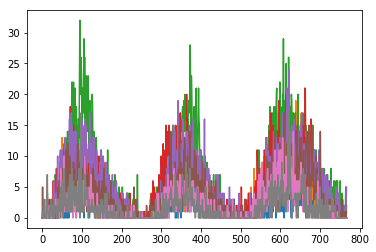

['haze',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'bare_ground']

In [41]:
xx = [0]+range(2,8)+[12] # плохие 600-4000
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


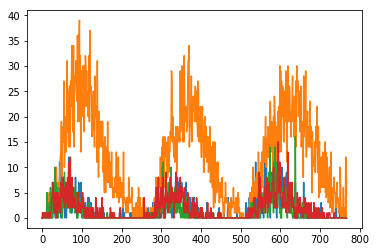

['slash_burn', 'partly_cloudy', 'blooming', 'selective_logging']

In [42]:
xx = [8,10,14,15] # среднии 100-400
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


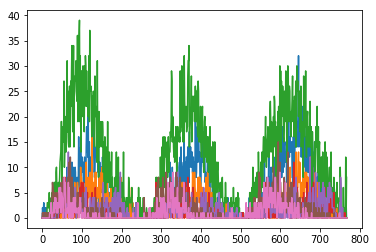

['primary',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'artisinal_mine',
 'selective_logging',
 'blow_down']

In [43]:
xx = [1,9,10,11,13,15,16] # отличные 0-100
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [44]:
# Посчитать уровень прохождения для каждого признака
ixx, iacc = getTh(trY,trYPP)
np.array(ixx), iacc

(array([ 0.4 ,  0.52,  0.45,  0.56,  0.35,  0.37,  0.46,  0.37,  0.14,
         0.47,  0.24,  0.05,  0.26,  0.14,  0.18,  0.25,  0.2 ]),
 [(40.0, 0.97247955730131674, 0.97161491143555923, 1114, 1149),
  (52.0, 0.99918476246942856, 0.99906124163146326, 33, 38),
  (45.0, 0.93174238494033945, 0.93030954321994119, 2763, 2821),
  (56.0, 0.99276167889522959, 0.99164999135354137, 293, 338),
  (35.0, 0.94305689369796686, 0.92383705131055605, 2305, 3083),
  (37.0, 0.99281108723041578, 0.98935250376738559, 291, 431),
  (46.0, 0.93626324760987178, 0.93480570172188049, 2580, 2639),
  (37.0, 0.92509696385780282, 0.91763630524469475, 3032, 3334),
  (14.0, 1.0, 0.99977766249166233, 0, 9),
  (47.0, 0.99508387064897852, 0.99493564564342007, 199, 205),
  (24.0, 1.0, 1.0, 0, 0),
  (5.0, 1.0, 1.0, 0, 0),
  (26.0, 0.99152647051557596, 0.98705501618122982, 343, 524),
  (14.0, 1.0, 1.0, 0, 0),
  (18.0, 0.99718372489438967, 0.99476271647026848, 114, 212),
  (25.0, 0.99945650831295241, 0.99772721658143726, 22,

In [45]:
# Forming output dataset for predicting --> trOX, trOY
#del(trX)
#del(trY)

In [46]:
# Данные для объединения от jpg
trOX  = np.load('../Work/t-'+str(10000+binsData)+jpgtif+'-XX-test.npy')
trOY  = np.load('../Work/t-'+str(10000+binsData)+jpgtif+'-YY-test.npy')

In [47]:
#trOX = dfOX.values
#trOY = dfOX.index.values
trOX.shape,trOY.shape,trOY[0:10]

((61191, 768),
 (61191,),
 array(['test_10002', 'test_10003', 'test_10004', 'test_10005',
        'test_10006', 'test_10007', 'test_10008', 'test_10009', 'test_1001',
        'test_10010'], 
       dtype='|S10'))

In [48]:
# Формирование результата
dtest  = xgb.DMatrix(trOX)

In [49]:
trP = []
for bstI in bstList :
    trP1 = bstI.predict(dtest);
    trP.append(trP1)
trP = np.array(trP).T
type(trP),trP.shape    

(numpy.ndarray, (61191, 17))

In [50]:
#np.save('../Work/test-data-RR'+str(binsData)+ttExt+'.npy',trP)

In [51]:
#trP = np.load('../Work/test-data-RR'+str(binsData)+ttExt+'.npy')
#trP.shape

In [52]:
wr = [labels.index(i) for i in weather_labels];
trM=np.array(ixx) #np.array([0.5]*17);
#### Коэффициенты работают +0.01 к счету trM=np.array([0.5]*17);
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.52, 0.45, 2.0, 0.35, 0.37, 0.46, 0.37, 0.14, 2.0, 2.0, 0.05, 0.26, 0.14, 0.18, 0.25, 0.2]


In [53]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trA1 = [weather_labels[trP[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])]
    trPP = trA1 + trA2;
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.    0.52  0.45  2.    0.35  0.37  0.46  0.37  0.14  2.    2.    0.05
  0.26  0.14  0.18  0.25  0.2 ] [  1.36969104e-01   1.02386318e-01   4.83063459e-02   1.69801041e-01
   3.10301065e-01   5.91836113e-04   1.74877662e-02   5.50486846e-03
   2.23991792e-05   8.47732663e-01   3.09935771e-04   4.39817586e-06
   4.28348500e-03   1.33315771e-05   1.09114888e-04   1.25199556e-04
   2.39833807e-05]


In [54]:
print(labels)
print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.52, 0.45, 2.0, 0.35, 0.37, 0.46, 0.37, 0.14, 2.0, 2.0, 0.05, 0.26, 0.14, 0.18, 0.25, 0.2]


In [55]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-04-01-55-35
